Обучение модели классификации наличия экранов ПК

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import gc
from PIL import ImageFile
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [41]:
import hashlib
import imagehash
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import Counter

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
RANDOM_STATE = 42

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Формирование выборки для обучения и теста

In [9]:
df_markup = pd.read_pickle('df_markup_nodupl_pcscreen.pkl')
df_markup.reset_index(drop=True, inplace=True)
df_markup.shape

(13147, 2)

In [13]:
df_markup.head()

,filename,phash,target
0,receipt_screen_data\new_terminals\IM0204731777...,1e91796aba66e42c6eafab5f50950136ae7354c3b28e75...,0
1,receipt_screen_data\new_terminals\IM0204764217...,cb3df177622386f59ec19815ab3b53718098bbeaf70f77...,0
2,receipt_screen_data\new_terminals\IM0204877219...,ba6e38519086876cdcb5cb0ad1083571e4f86d493ccd55...,0
3,receipt_screen_data\new_terminals\IM0204884147...,99e3cc9730e0455aa6ada16f757a67050bb562b650b386...,0
4,receipt_screen_data\new_terminals\TS904426580-...,99fe828863800f8ac43067094dc53880b513a8edb82cbf...,0


In [18]:
TEST_SIZE = 0.25

In [19]:
flag_augm = df_markup['filename'].apply(lambda x: 'augm' in x)
train_augm = df_markup.loc[flag_augm]

train, test = train_test_split(
    df_markup.loc[~flag_augm], stratify=df_markup.loc[~flag_augm, 'target'],
    random_state=RANDOM_STATE, test_size=TEST_SIZE)
train = pd.concat((train_augm, train))

In [20]:
train['target'].value_counts()

target
0    5766
1    5137
Name: count, dtype: int64

In [21]:
test['target'].value_counts()

target
0    1922
1     322
Name: count, dtype: int64

In [22]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    normalize
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    normalize
])

In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None, filename=False):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column
        self.filename = filename

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        file_name = self.data.iloc[idx]['filename']
        img = Image.open(file_name).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.filename:
            return img, label, file_name
        return img, label

In [24]:
NUM_WORKERS = 0
BATCH_SIZE = 32

train_dataset = CustomDataset(train, target_column='target', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test, target_column='target', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Обучение модели

In [25]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [26]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls):
    clear_output()
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='train', marker='o')
    axs[0, 0].plot(range(1, len(test_losses) + 1), test_losses, label='test', marker='o')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', marker='o')
    axs[0, 1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test', marker='o')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    axs[0, 2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train', marker='o')
    axs[0, 2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test', marker='o')
    axs[0, 2].set_ylabel('F1')
    axs[0, 2].legend()

    axs[1, 0].plot(range(1, len(train_precisions) + 1), train_precisions, label='train', marker='o')
    axs[1, 0].plot(range(1, len(test_precisions) + 1), test_precisions, label='test', marker='o')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()

    axs[1, 1].plot(range(1, len(train_recalls) + 1), train_recalls, label='train', marker='o')
    axs[1, 1].plot(range(1, len(test_recalls) + 1), test_recalls, label='test', marker='o')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    # for ax in axs:
    #     ax.set_xlabel('epoch')
    #     ax.legend()
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, train_f1, train_precision, train_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        train_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)

    return train_loss, train_accuracy, train_f1, train_precision, train_recall


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1, test_precision, test_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)
    test_precision /= len(test_loader)
    test_recall /= len(test_loader)

    return test_loss, test_accuracy, test_f1, test_precision, test_recall


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s, train_precisions, train_recalls = [], [], [], [], []
    test_losses, test_accuracies, test_f1s, test_precisions, test_recalls = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1, train_precision, train_recall = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1, test_precision, test_recall = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        train_precisions += [train_precision]
        train_recalls += [train_recall]

        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        test_precisions += [test_precision]
        test_recalls += [test_recall]
        plot_losses(
            train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls
          )
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'test_loss': test_losses[-1],
            'train_accuracy': train_accuracies[-1],
            'test_accuracy': test_accuracies[-1],
            'train_f1': train_f1s[-1],
            'test_f1': test_f1s[-1],
            'train_precision': train_precisions[-1],
            'test_precision': test_precisions[-1],
            'train_recall': train_recalls[-1],
            'test_recall': test_recalls[-1]
        }, models_dir+f'/model_pcscreen_nodupl_ep{epoch}.pth')

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls

In [27]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

In [28]:
model_pcscreen = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
model_pcscreen.classifier[3] = torch.nn.Linear(1280, 2)
model_pcscreen = model_pcscreen.to(device)

In [29]:
num_epochs = 40
optimizer = torch.optim.SGD(model_pcscreen.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


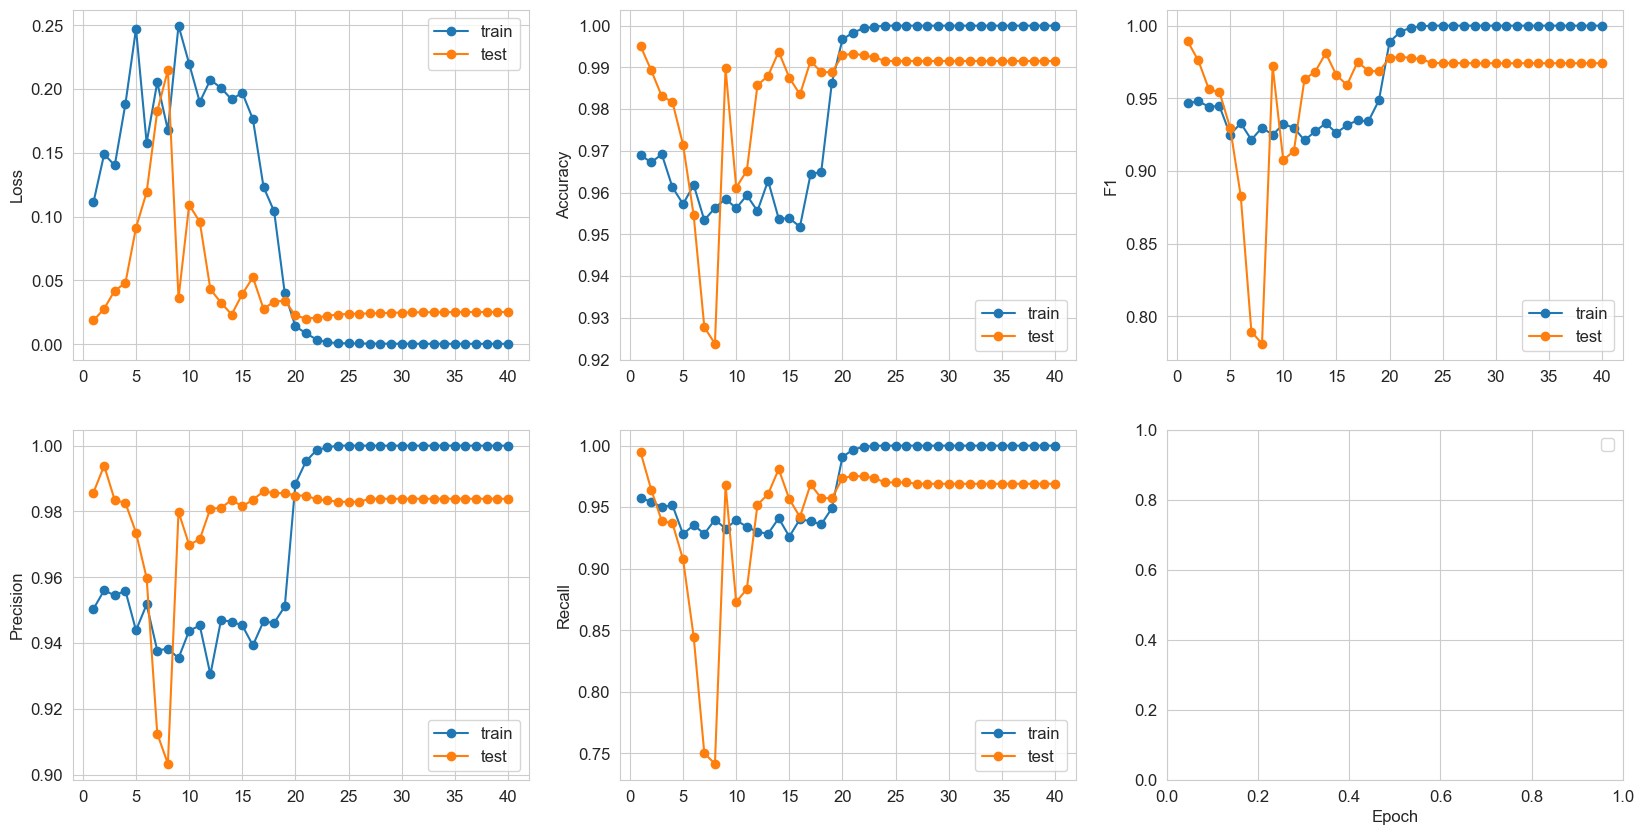

In [30]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls = train(
    model_pcscreen, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)

In [33]:
model_pcscreen = mobilenet_v3_large()
model_pcscreen.classifier[3] = torch.nn.Linear(1280, 2)
state_dict = torch.load('models/model_pcscreen_nodupl_ep21.pth')
model_pcscreen.load_state_dict(state_dict['model_state_dict'])
model_pcscreen = model_pcscreen.to(device)
model_pcscreen.eval()
clear_output()

In [34]:
all_preds, all_labels = [], []
for images, labels in tqdm(test_dataloader):
    predicts = model_pcscreen(images.to(device)).argmax(dim=1)
    all_preds.append(predicts)
    all_labels.append(labels)

100%|██████████| 71/71 [00:39<00:00,  1.78it/s]


In [35]:
all_preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
all_labels = np.hstack([labels.cpu().numpy() for labels in all_labels])

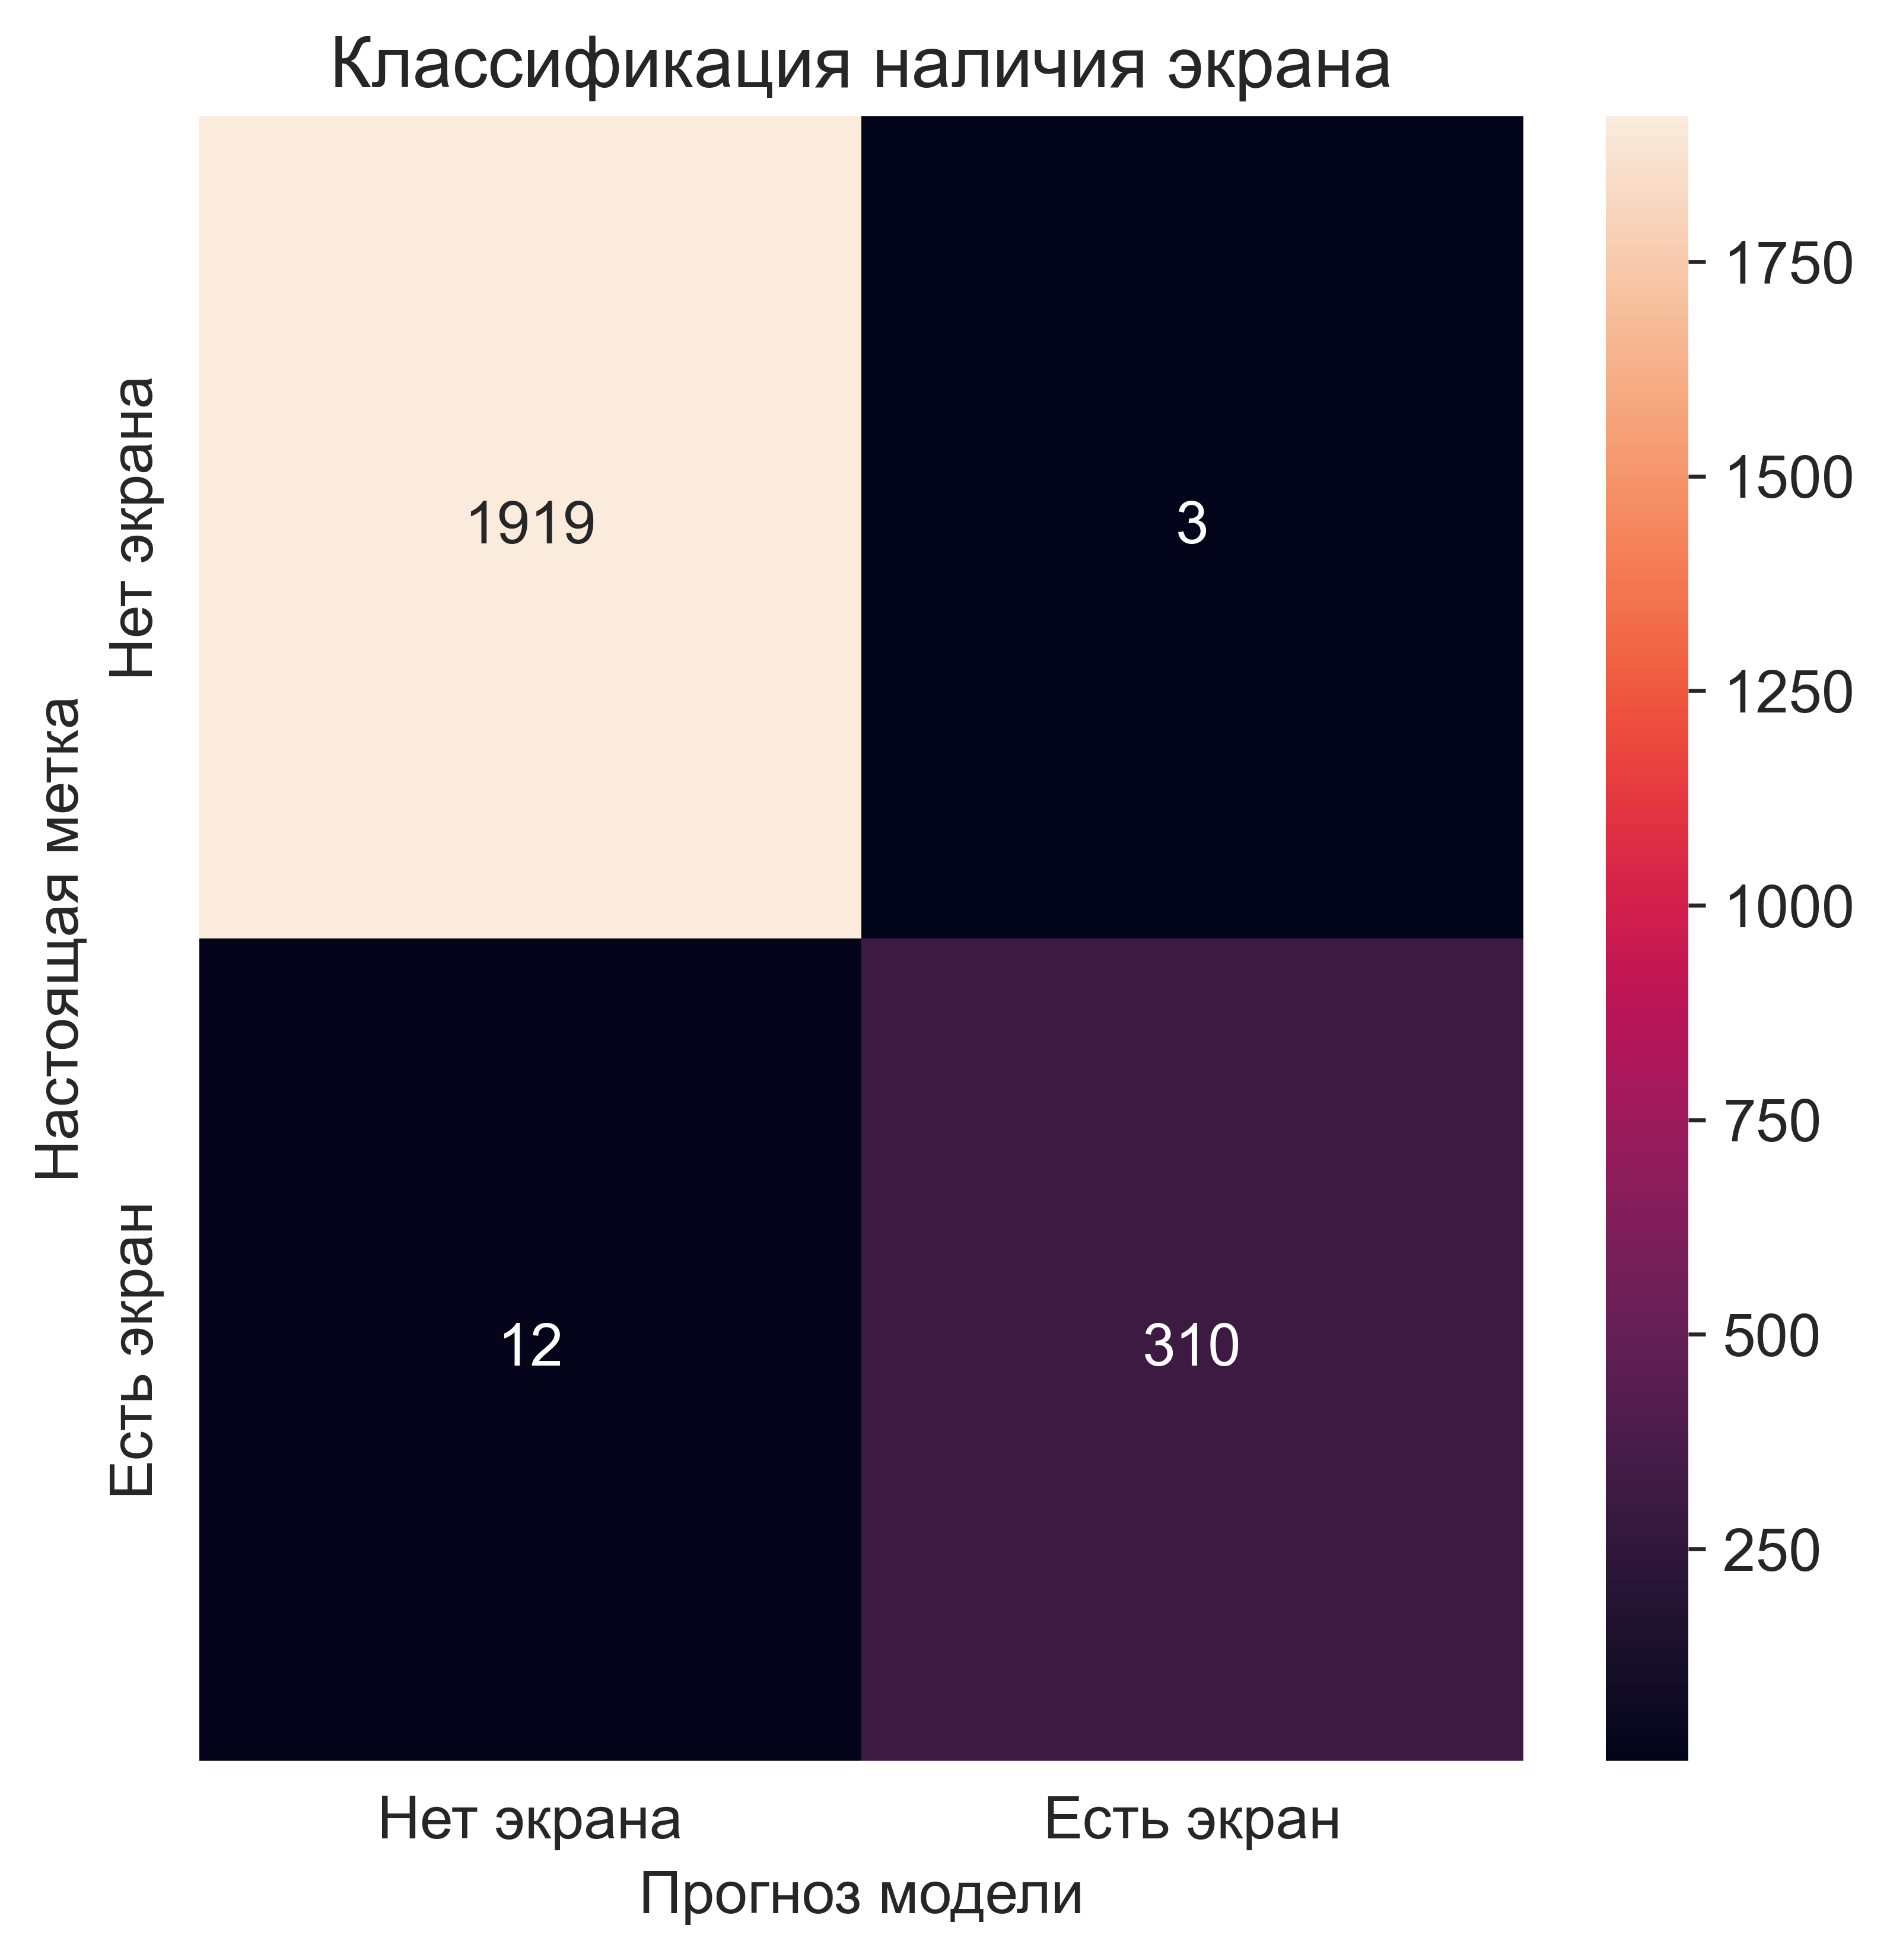

In [36]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6), dpi=600)
sns.heatmap(cm, annot=True, fmt='d', yticklabels=['Нет экрана', 'Есть экран'], xticklabels=['Нет экрана', 'Есть экран'])
plt.xlabel('Прогноз модели')
plt.ylabel('Настоящая метка')
plt.title('Классификация наличия экрана')
plt.show()

# Валидация на случайном сэмпле за 10.11.23

In [38]:
path_data = Path('val_data')

In [39]:
filenames_val = []
for folder in os.listdir(path_data):
    filenames_val.extend(
        (path_data / folder / x).__str__() for x in os.listdir(path_data / folder)
    )

In [42]:
hash_size = 8
def phash(image: Image.Image, hash_size: int) -> str:
    return str(
        hashlib.sha256(
            bytearray(
                imagehash.phash(
                    image, hash_size=hash_size
                ).hash.flatten().astype(int).tolist())
            ).hexdigest())

In [43]:
hashes = []
for file in tqdm(filenames_val):
    file_hash = phash(Image.open(file), hash_size)
    hashes.append(file_hash)

100%|██████████| 1000/1000 [00:08<00:00, 122.93it/s]


In [44]:
df = pd.DataFrame(
    {
        'filename': filenames_val,
        'phash': hashes
    }
)
df.head()

,filename,phash
0,val_data\other\IM0206566837_21862019_01476185_...,271f6a8d918a5f097d202221a992b38352dfcd324c4dc9...
1,val_data\other\IM0206826136_21989243_30633561_...,8f86cebd670f74a8f4a5b0763457e69359f8d42e8315fb...
2,val_data\other\IM0207018394_22095985_21638721_...,db4ad5d8512d5155e6d6f3337e00ce431a57b6ae04afda...
3,val_data\other\IM0207025966_22101033_24231957_...,c3b4197abd907ac44c9b6feadd18caca9d8f99f9747a81...
4,val_data\other\IM0207033584_22105963_20469951_...,fef679cceded7deef5e804249042fa991522c7959d58bd...


In [45]:
counter = Counter(df['phash'])
df_hashes = pd.DataFrame(
    {
        'phash': list(counter.keys()),
        'count': list(counter.values())
    }
)
n_dupl = df_hashes[df_hashes['count']>1]['count'].sum()
print(f'Количество фото с дубликатами: {n_dupl}')

Количество фото с дубликатами: 39


In [50]:
df['target'] = 0
df.loc[
    df['filename'].apply(lambda x: x.split('\\')[-2]=='pcscreen'),
    'target'
] = 1

In [53]:
df.drop_duplicates(subset=['phash'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [54]:
df.shape

(979, 3)

In [55]:
val_dataset = CustomDataset(df, target_column='target', transform=test_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [59]:
all_preds, all_labels = [], []
for images, labels in tqdm(val_dataloader):
    predicts = model_pcscreen(images.to(device)).argmax(dim=1)
    all_preds.append(predicts)
    all_labels.append(labels)

100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


In [60]:
all_preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
all_labels = np.hstack([labels.cpu().numpy() for labels in all_labels])

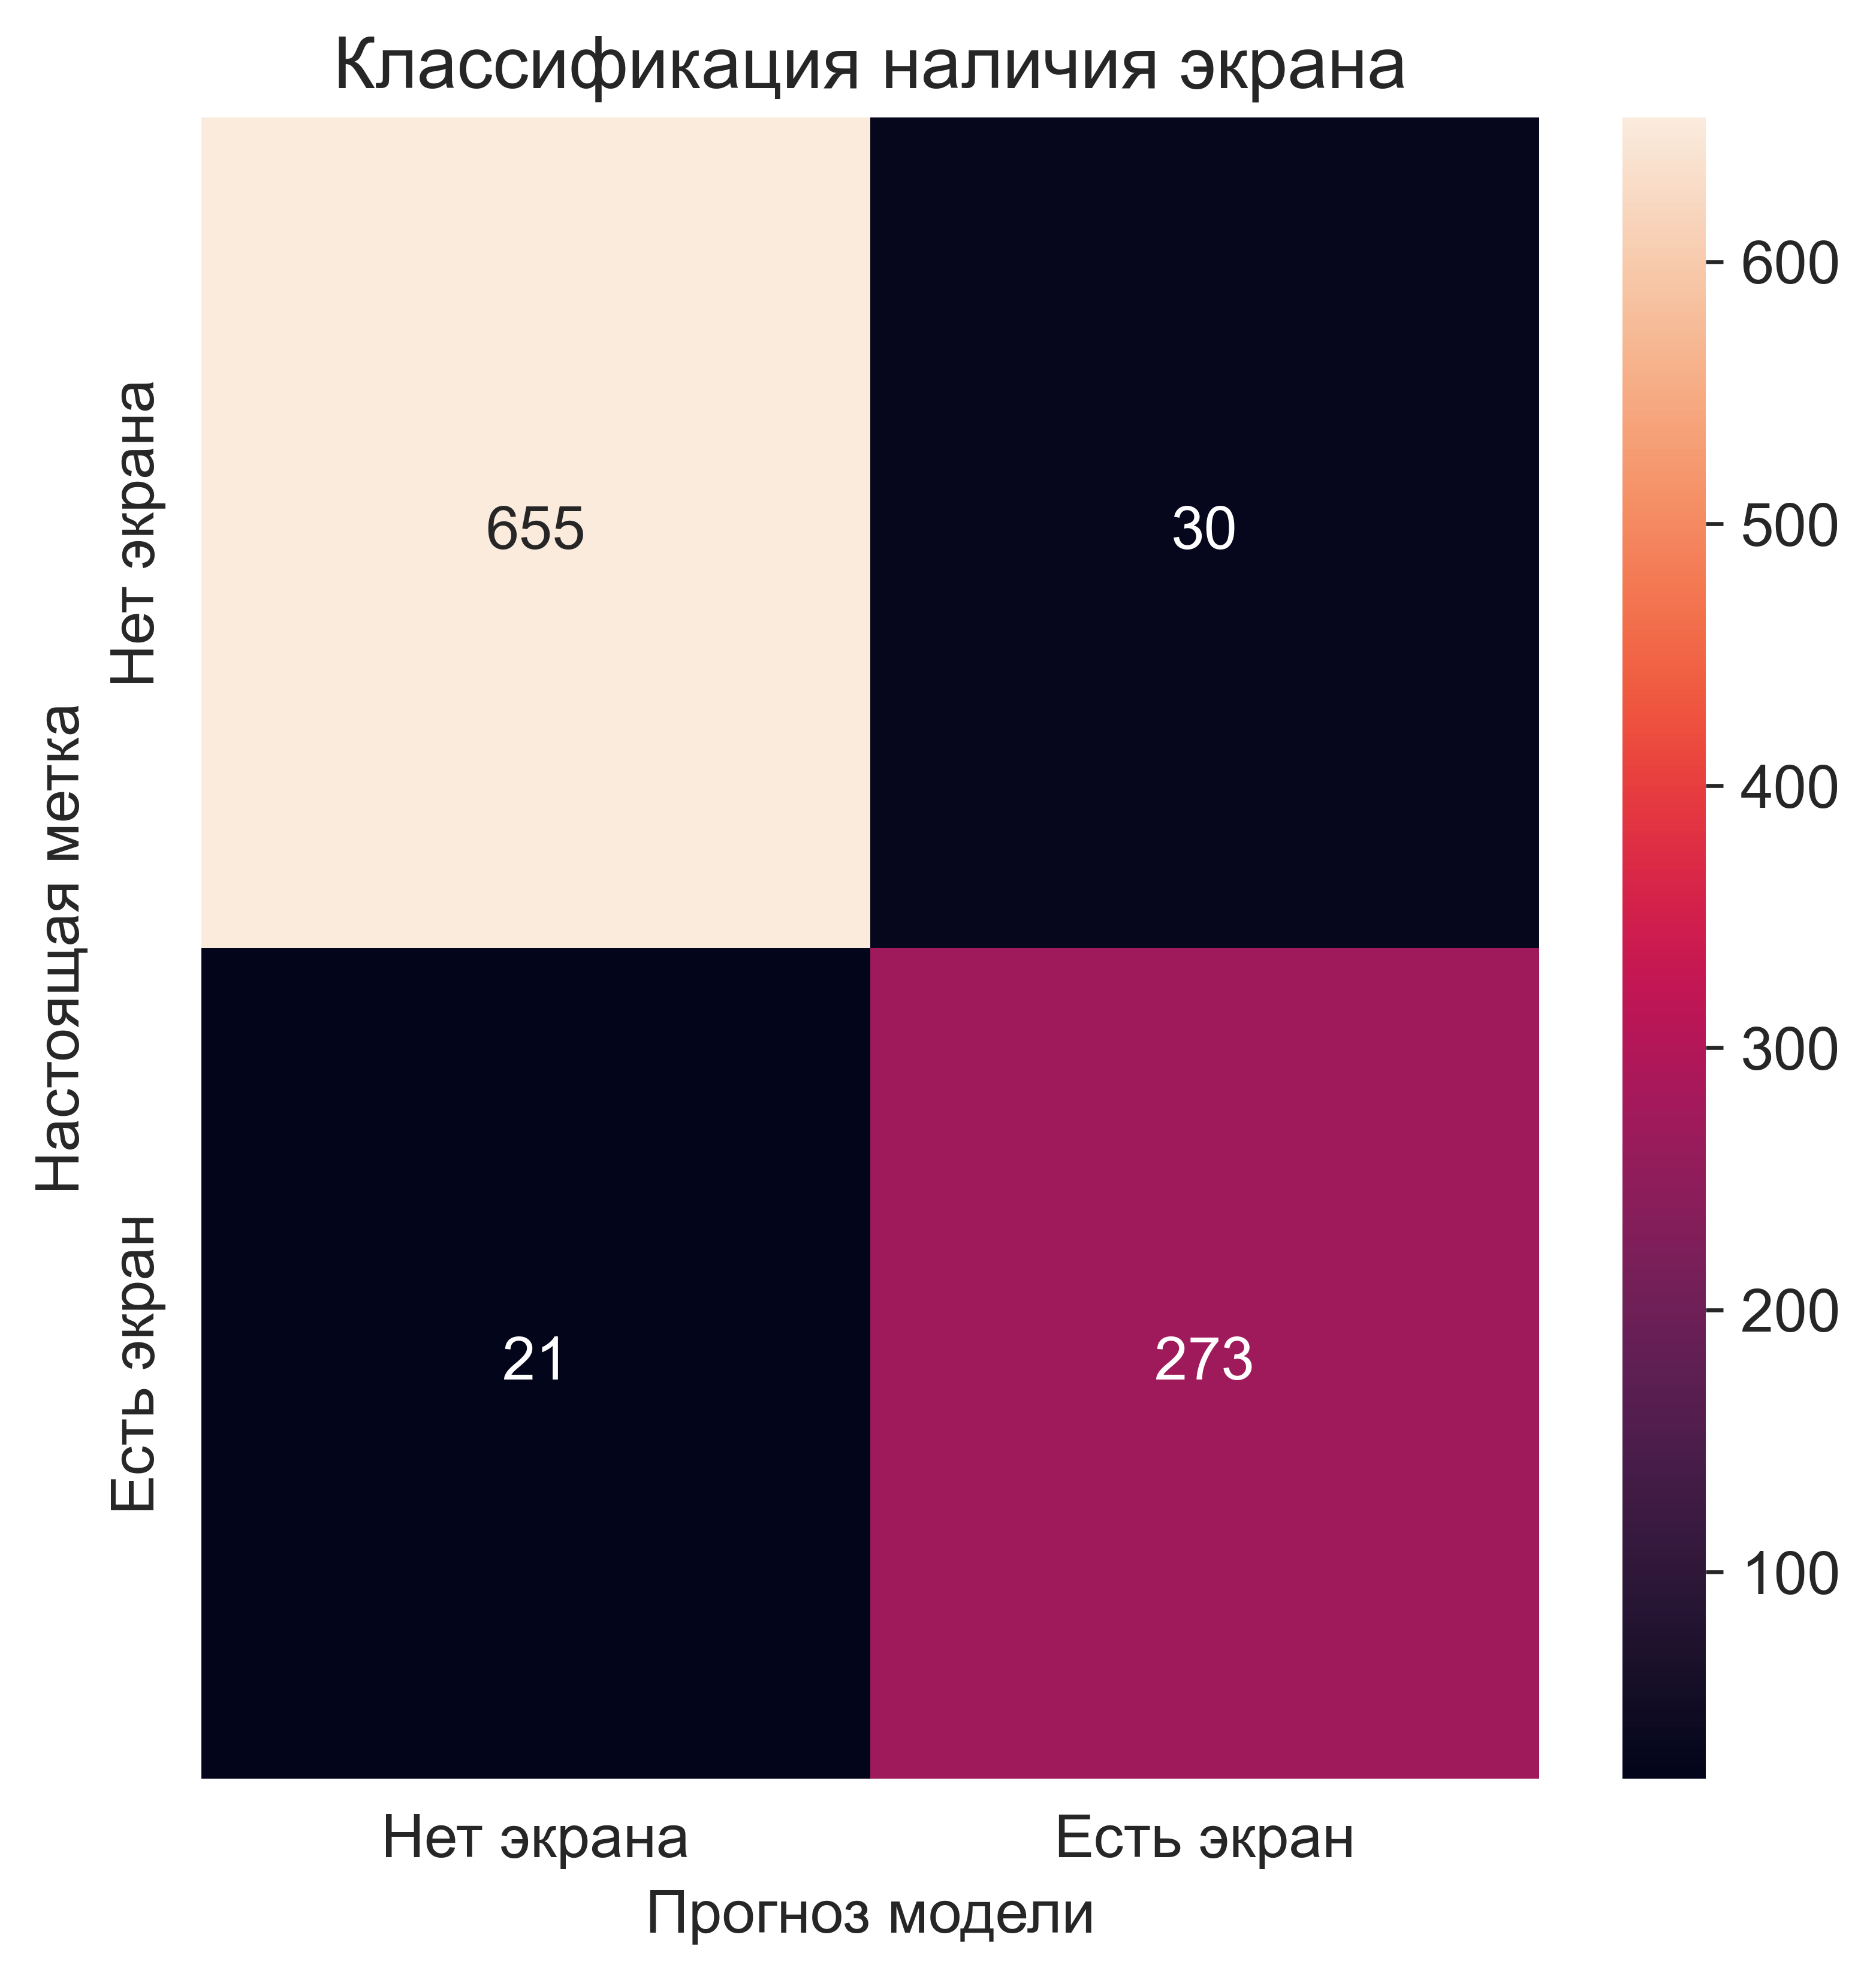

In [61]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6), dpi=600)
sns.heatmap(cm, annot=True, fmt='d', yticklabels=['Нет экрана', 'Есть экран'], xticklabels=['Нет экрана', 'Есть экран'])
plt.xlabel('Прогноз модели')
plt.ylabel('Настоящая метка')
plt.title('Классификация наличия экрана')
plt.show()

In [65]:
print(f'Precision:\t{precision_score(all_labels, all_preds):.4f}')
print(f'Recall:\t{recall_score(all_labels, all_preds):.4f}')
print(f'F1:\t{f1_score(all_labels, all_preds):.4f}')

Precision:	0.9010
Recall:	0.9286
F1:	0.9146


'models'

In [71]:
torch.save(model_pcscreen, 'models/model_pcsreen_v2.pt')